In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.cluster import DBSCAN, KMeans
from IPython.display import display, HTML

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

home_path = "/home/**************"
assignment1a_path = home_path + "assignment4.1a.csv"
assignment1b_path = home_path + "assignment4.1b.csv"
assignment1c_path = home_path + "assignment4.1c.csv"
promotions_path = home_path + "PromotionDates.csv"

sales1a = pd.read_csv(assignment1a_path)
features1c = pd.read_csv(assignment1c_path)
sales1b = pd.read_csv(assignment1b_path)
all_promotions = pd.read_csv(promotions_path)

In [2]:
def promo_and_non_promo(sales, promotions):
    #Printing the shape of sales csv
    print(f'- {sales.shape[0]} rows, {sales.shape[1]} columns')
    #Check if any null values 
    print(f'- there are {sales.isnull().values.sum()} null values in the data frame')
    # Test omit zero values in sales quantity
    #sales1a = sales1a[sales1a['SalesQuantity'] != 0]
    # only non-zero sales (1282628, 4)
    
    # # of stores and # of products
    n_product, n_store = len(sales['ProductCode'].unique()), len(sales['StoreCode'].unique())
    print(f"- number of stores: {n_store}, number of product: {n_product}\n")

    #add date variables iso.week,
    sales["DateTime"] = pd.to_datetime(sales['Date'])
    sales["Week"] = sales['DateTime'].dt.isocalendar().week
    n_week = len(sales["Week"].unique())

    # mask for non-promotion times
    promotions['StartDate'] = pd.to_datetime(promotions['StartDate'],format="%m/%d/%Y")
    promotions['EndDate'] = pd.to_datetime(promotions['EndDate'])
    
    print(promotions['StartDate'].dtype == 'datetime64[ns]')
    print(promotions['EndDate'].dtype == 'datetime64[ns]')
    print('hoop')
    
    print("Promotion Dates")
    print(pd.concat([promotions['StartDate'].dt.isocalendar().week, promotions['EndDate'].dt.isocalendar().week,
                     promotions['StartDate'].dt.day_name(), promotions['EndDate'].dt.day_name()], axis=1).to_string(index=False))
    
    #print("While calculating the weekly averages(see below) it would better to disregard week 7, 12, 22, 26 \
    #since most of the days in those weeks are on promotion.\n")

    sales["Time"] = "Non-Promo"
    for i, p in promotions.iterrows():
        sales.loc[(p.StartDate <= sales['DateTime']) & (sales['DateTime'] <= p.EndDate), "Time"] = p.Period

    no_promotion = sales["Time"] == "Non-Promo"
    non_promo_sales = sales[no_promotion]
    promo_sales = sales[~no_promotion]
    
    print("\nPromo vs Non Promo Time")
    print("# of no promo sales", non_promo_sales.shape)
    print("# of promo sales", promo_sales.shape)

    return promo_sales, non_promo_sales
    #Product got sold  on promo time and non-promo time

In [3]:
promotions_a = all_promotions.iloc[:4].copy()
promo_sales_a, non_promo_sales_a = promo_and_non_promo(sales1a, promotions_a )
promo_weeks_a = {7, 12, 22, 26}
print('promo_weeks',promo_weeks_a)

all_products = set(np.arange(len(sales1a['ProductCode'].unique()))+1)
all_stores = set(np.arange(len(sales1a['StoreCode'].unique()))+1)
n_week_a = len(sales1a["Week"].unique())
n_product, n_store = len(all_products), len(all_stores)
print(sales1a.groupby(['Time']).size())

- 1873618 rows, 4 columns
- there are 0 null values in the data frame
- number of stores: 340, number of product: 317

True
True
hoop
Promotion Dates
 week  week StartDate EndDate
    7     8   Tuesday Tuesday
   11    12    Sunday  Sunday
   21    23    Sunday  Monday
   25    26    Sunday  Sunday

Promo vs Non Promo Time
# of no promo sales (1562695, 7)
# of promo sales (310923, 7)
promo_weeks {26, 12, 22, 7}
Time
Non-Promo    1562695
Promo1         80876
Promo2         85678
Promo3         76546
Promo4         67823
dtype: int64


In [4]:
# Note: by saying item I mean it could be product or store 
item_pair = {'Product':'Store', 'Store': 'Product'}
'''
PROMO
Returns the weekly sales for each PxSxW triplet
'''
def promo_sale_to_weekly(promo_sales):
    promo_weekly = promo_sales.groupby(['ProductCode','StoreCode', 'Time'])['SalesQuantity'].sum()
    return promo_weekly.reset_index()

'''
NON-PROMO
Returns the weekly sales for each PxSxW triplet 
'''
def non_promo_sale_to_weekly(non_promo_sales, promo_weeks):
    non_promo_weekly = non_promo_sales[~non_promo_sales["Week"].isin(promo_weeks)].groupby(['ProductCode','StoreCode','Week'])['SalesQuantity'].sum()
    return non_promo_weekly.reset_index()

'''
PROMO Or NON-PROMO
Returns avg item per other_item for each week(promotion period), in other words, weekly item per other_item 
'''
def item_avg_weekly_per_other(promo, item_name, p_np_sales, all_items, promo_weeks):
    if promo == 'PROMO':
        weekly = promo_sale_to_weekly(p_np_sales)
        week = 'Time' 
    else:
        weekly = non_promo_sale_to_weekly(p_np_sales, promo_weeks)
        week = 'Week'
        
    item_code = item_name + 'Code'    
    i_weekly_per_other = weekly.groupby([item_code, week])['SalesQuantity'].mean()
    return i_weekly_per_other.reset_index()

'''
PROMO or NON-PROMO
Item average of weekly(or promotionly) item sales per other item
'''
def item_avg(promo, item_name, p_np_sales, all_items, promo_weeks=None):

        item_code = item_name + 'Code'
    
        i_avg_weekly_per_other = item_avg_weekly_per_other(promo, item_name, p_np_sales, all_items, promo_weeks)
        i_avg = i_avg_weekly_per_other.groupby([item_code])['SalesQuantity'].mean()
    
        missing = pd.Series({ el : 0 for el in all_items.difference(set(i_avg.index))})
        missing = missing.rename_axis(item_code)
        i_avg = pd.concat([i_avg, missing])
        i_avg = i_avg.sort_index()

        #product_non_promo_avg = pd.Series(X_product.mean(axis=1), np.arange(X_product.shape[0])+1)
        i_avg = i_avg.rename_axis('ProductCode')
        i_avg.name = item_name[0] + ("_non" if promo == "NON-PROMO" else "") +  "_promo_avg_SQ"
        return i_avg

In [5]:
#NON- PROMO 
#Non-promo time PxSxWeekly Sales
non_promo_weekly_a = non_promo_sale_to_weekly(non_promo_sales_a, promo_weeks_a)

#Non-promo time weekly P per S Sales
non_promo_product_weekly_per_store_a = item_avg_weekly_per_other(promo='NON-PROMO',
                                                               item_name = 'Product',
                                                               p_np_sales = non_promo_sales_a,
                                                               all_items = all_products,          
                                                               promo_weeks = promo_weeks_a) 

#Non-promo time weekly S per P Sales 
non_promo_store_weekly_per_product_a = item_avg_weekly_per_other(promo='NON-PROMO',
                                                               item_name = 'Store',
                                                               p_np_sales = non_promo_sales_a,
                                                               all_items = all_stores,
                                                               promo_weeks = promo_weeks_a) 


#Non-promo time AVG weekly P per S Sales
non_promo_product_avg_a = item_avg(promo = 'NON-PROMO', 
                                 item_name = 'Product', 
                                 p_np_sales = non_promo_sales_a,
                                 all_items = all_products,
                                 promo_weeks=promo_weeks_a)

#Non-promo time AVG weekly S per P Sales
non_promo_store_avg_a = item_avg(promo = 'NON-PROMO', 
                                 item_name = 'Store', 
                                 p_np_sales = non_promo_sales_a,
                                 all_items = all_stores,
                                 promo_weeks=promo_weeks_a)

<h2>A-a,b</h2>

<h1>FAST-SLOW-MEDIUM</h1>

In [6]:
#red - fast, green - medium, blue - slow
labels = [('fast','red', 1), ('medium','green', 0), ('slow','blue', -1)]

def cluster_item(item_type, n_item, item_weekly, promo_weeks=promo_weeks_a, n_week=n_week_a, show=True):
    item_code = item_type+'Code'
    ## K-MEANS to CLUSTER PRODUCTS
    #prepare data 
    X_item = np.zeros((n_item, n_week))
    
    for item_id in item_weekly[item_code].unique():
        p = item_weekly[item_weekly[item_code]== item_id]    
        for w, sq in zip(p.Week, p.SalesQuantity):
            X_item[item_id-1][w-1] = sq 
    
    c_to_drop = [w-1 for w in promo_weeks]
    
    X_item = np.delete(X_item, c_to_drop, axis=1)
    
    kmeans_item = KMeans(
        init="random",
        n_clusters=3,
        n_init=1000,
        max_iter=1000,
        random_state=1
    )
    
    kmeans_item.fit(X_item)
    
    centers = kmeans_item.cluster_centers_.mean(axis=1)
    sorted_index = [i for i, x in sorted(enumerate(centers), key=lambda x: x[1], reverse=True)]
    item_hsh = { cls:i for i, cls in enumerate(sorted_index)}


    # cluster labels of items
    item_non_promo_type = pd.Series([ labels[item_hsh[l]][0] for l in kmeans_item.labels_], np.arange(n_item)+1, 
                                         name=item_type[0]+"_non_promo_type")
    
    item_non_promo_color = pd.Series([ labels[item_hsh[l]][1] for l in kmeans_item.labels_], np.arange(n_item)+1, 
                                         name=item_type[0]+"_non_promo_color")
    
    
    unique_values, counts = np.unique(kmeans_item.labels_, return_counts=True)
    counts = counts/n_item
    x = [labels[item_hsh[val]][0] for val in unique_values]
    item_type_dist = pd.Series(counts,index=x)
    item_type_dist = item_type_dist.reindex(['slow','medium','fast'])

    
    item_non_promo_label = pd.concat([item_non_promo_type, item_non_promo_color], axis=1)
    item_non_promo_label[item_type + '_type_dist_w'] = item_non_promo_type.apply(lambda x: item_type_dist[x])
    
    if show:
        for label, idx  in enumerate(sorted_index):
            c = kmeans_item.cluster_centers_[idx]
            plt.title(f"{item_type} Cluster_{labels[label][0]}")
            plt.bar(np.arange(len(c)), c, color=labels[label][1])
            plt.xlabel('Week')
            plt.ylabel('Avg Sale')
            plt.show()
       
        plt.title(f"{item_type} type distribution")
        plt.bar(item_type_dist.index, item_type_dist, color=['blue','green','red'])
        plt.ylim(0.0, 1.0)
        plt.xlabel('Cluster Type')
        plt.ylabel('%')
        plt.show()
    
    return kmeans_item, item_non_promo_label, item_hsh, X_item


In [9]:
p_types =  non_promo_product_label['P_non_promo_type']
p_types.index.name = "ProductCode"
p_types.name='P_type'
print(p_types.reset_index())


s_types =  non_promo_store_label['S_non_promo_type']
s_types.index.name = "StoreCode"
s_types.name='S_type'
print(s_types.reset_index())

     ProductCode  P_type
0              1  medium
1              2    slow
2              3    slow
3              4    slow
4              5    slow
..           ...     ...
312          313    slow
313          314    slow
314          315    slow
315          316    slow
316          317    slow

[317 rows x 2 columns]
     StoreCode  S_type
0            1  medium
1            2    fast
2            3    slow
3            4  medium
4            5    slow
..         ...     ...
335        336    slow
336        337  medium
337        338  medium
338        339  medium
339        340  medium

[340 rows x 2 columns]


In [10]:
p_types.reset_index().to_csv(home_path+"product_types.csv")
s_types.reset_index().to_csv(home_path+"store_types.csv")


**K-Means: Product and Stores**

PRODUCTS


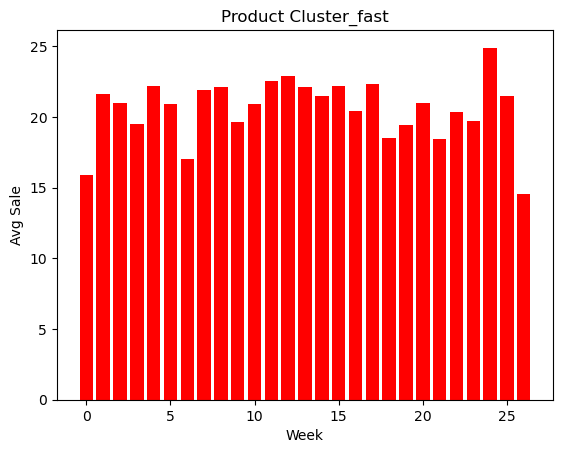

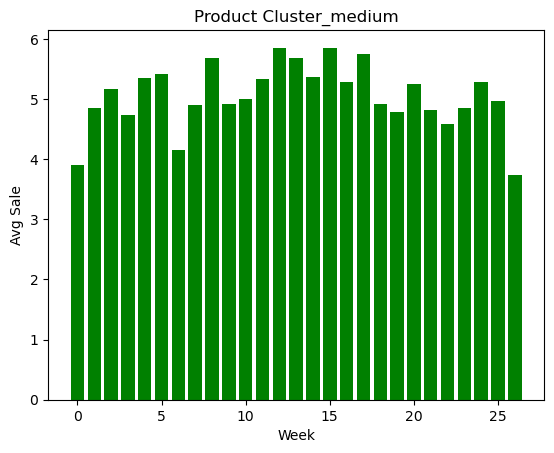

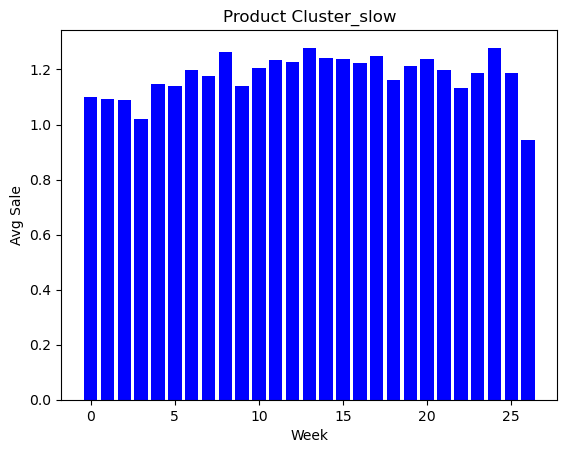

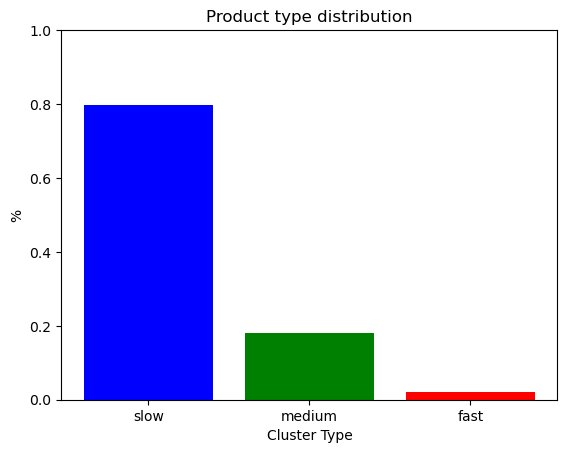

[ 5.05135289  1.17832262 20.54533615]
STORES


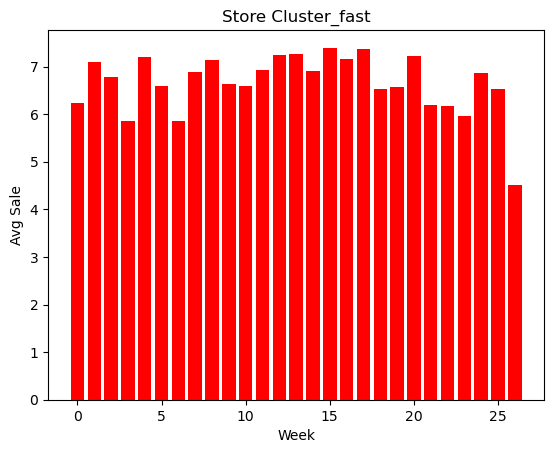

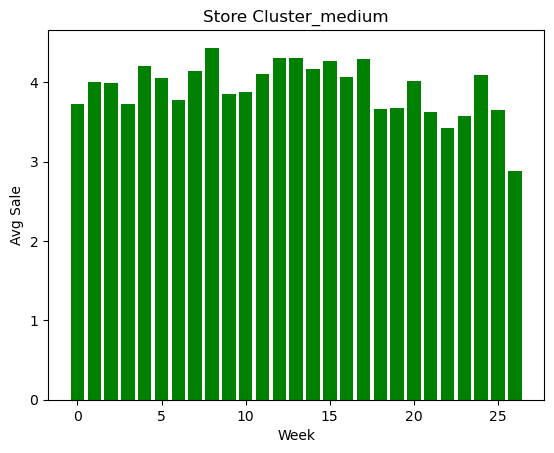

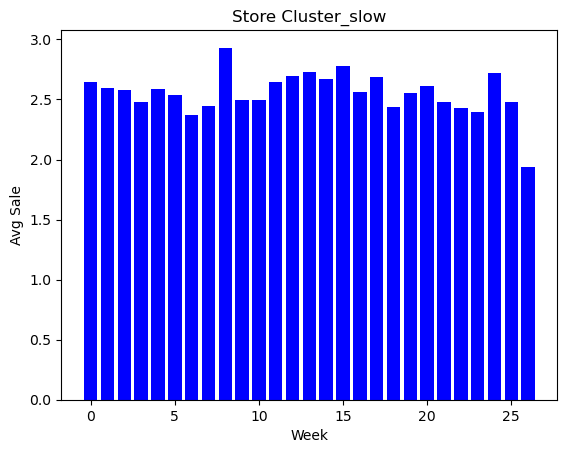

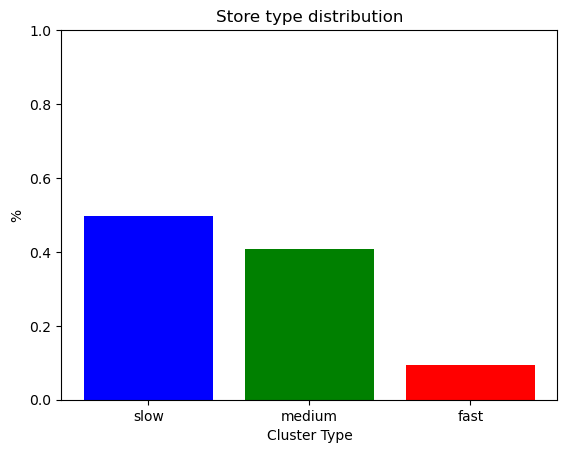

[6.65445906 3.92483015 2.55466541]


In [8]:
type = 'Non-Promo'
show=True

print("PRODUCTS")
kmeans_p, non_promo_product_label, p_hsh, X_product = cluster_item(item_type = 'Product',
                                                                   n_item = n_product,
                                                                   item_weekly = non_promo_product_weekly_per_store_a, 
                                                                   show=show)

centers_avg_p = kmeans_p.cluster_centers_.mean(axis=1)
print(centers_avg_p)

print("STORES")
kmeans_s, non_promo_store_label, s_hsh, X_store = cluster_item(item_type = 'Store',
                                                               n_item = n_store,
                                                               item_weekly = non_promo_store_weekly_per_product_a,
                                                               show=show)

centers_avg_s = kmeans_s.cluster_centers_.mean(axis=1)
print(centers_avg_s)

<h1>A- c, d</h1>

In [8]:
def item_relative_impact(item_type, n_item, 
                         item_promo_avg, 
                         item_non_promo_avg, 
                         item_non_promo_label,
                         item_hsh, centers_item,
                         n_week=n_week_a, 
                         show=True, epsilon=10**-8):
    
    print("RELATIVE IMPACT")
    item_impact_perc = (item_promo_avg - item_non_promo_avg) / (item_non_promo_avg.abs() + epsilon)
    item_impact_perc.name = item_type[0] + '_relative_impact'
    
    #Item - Plotting the distribution of impacts
    sorted_item_impact_perc = item_impact_perc.sort_values()#inplace = false default
    if show:
        plt.figure(figsize=(55, 30))
        plt.title(f"Impact percentage of each {item_type}", fontsize=58)
        plt.bar(np.arange(n_item), sorted_item_impact_perc, 
                color=[item_non_promo_label.iloc[:,1][p] for p in sorted_item_impact_perc.index])
        # Adjust the fontsize as needed
        plt.xticks(fontsize=46)
        plt.yticks(fontsize=46)  
        plt.xlabel(F"{item_type}", fontsize=32)
        plt.ylabel(item_type[0]+'_relative Impact', fontsize=32)
        if item_type == "Store":
            plt.ylim(-1.3, 3)
        else:
            plt.ylim(-2, 15)  # Change the limits based on your requirements
        plt.legend(handles=[mpatches.Patch(color=color, label=category) for (category, color, _) in labels], loc='upper left', prop={'size': 42})
        plt.show()
    
    # Show top 40 and worst 40
        n = 40
        top = sorted_item_impact_perc.iloc[:n] 
        bottom = sorted_item_impact_perc.iloc[-n:]
        top_n_bot = pd.concat([top, bottom])
        
        plt.figure(figsize=(25, 10))
        plt.title(f"{item_type} relative impact of top and bottom {n}", fontsize=20)
        plt.bar(top_n_bot.index.astype(str), top_n_bot, 
                color=[item_non_promo_label.iloc[:,1][p] for p in top_n_bot.index])
        
        plt.axvline(x=len(top_n_bot)//2-0.5, color='purple', linestyle='--', linewidth=3)
        
        plt.xticks(fontsize=14,rotation='vertical')
        plt.yticks(fontsize=16)
        plt.xlabel(F"{item_type}_id")
        plt.ylabel(item_type[0]+'_relative Impact')

        if item_type == "Store":
            plt.ylim(-1.3, 3)
        else:
            plt.ylim(-2, 15)  # Change the limits based on your requirements

        plt.legend(handles=[mpatches.Patch(color=color, label=category) for (category, color, _) in labels], 
                   loc='upper left', prop={'size': 16})
        plt.show()
        
    
    #Creating features for item: non promo sales, promo sales, non_promo class, promo_class, class change, perc impact
    closest_item_c = lambda x: item_hsh[np.abs(centers_item - x).argmin()]
    item_promo_labels = pd.Series([labels[closest_item_c(avg)][0] for avg in item_promo_avg], 
                                     np.arange(n_item)+1, name=item_type[0]+"_promo_type")

    item_features = pd.concat([item_non_promo_avg, item_promo_avg,
                                  item_non_promo_label.iloc[:,0], item_promo_labels,
                                  item_impact_perc.sort_index()], axis=1)
    item_features.index.name = item_type + "Code"

    #avg fast, medium, slow item relative impact
    if item_type == "Product":
        label_avg_impact = item_features[item_features.index !=163].groupby([item_promo_labels.name])[item_type[0]+'_relative_impact'].mean()
        print(label_avg_impact)
    else:
        label_avg_impact = item_features.groupby([item_promo_labels.name])[item_type[0]+'_relative_impact'].mean()
        print(label_avg_impact)

    if show:
        t_colors = {'fast':'red', 'slow':'blue', 'medium':'green'} 
        plt.title(f"Avg relative impact for {item_type} types")
        plt.bar(label_avg_impact.index, label_avg_impact.values, color = [t_colors[t] for t in label_avg_impact.index])
        plt.xlabel(F"{item_type}_type")
        plt.ylabel('Avg Impact')
        plt.ylim(0, 1.0)
        plt.show()
    
    item_features[item_type[0]+'_type_avg_impact'] = item_features[item_type[0]+'_non_promo_type'].apply(lambda x: label_avg_impact.loc[x])
   
    lookup = {('slow','slow'): 0, ('fast','fast'): 0,('medium','medium'): 0,
              ('slow','medium'): 1, ('medium','fast'): 1,('slow','fast'): 1,
              ('medium','slow'): -1, ('fast','slow'): -1,('fast','medium'): -1}
    item_features[item_type[0]+'_type_shift'] = item_features.apply(lambda x:lookup[(x[item_type[0]+'_non_promo_type'],x[item_type[0]+'_promo_type'])],
                                                      axis=1)
    
    #no of cluster change for each item 
    

    return item_features
    #Show if there is any label change slow to fast slow to medium etc, check the number of label changes per label


RELATIVE IMPACT


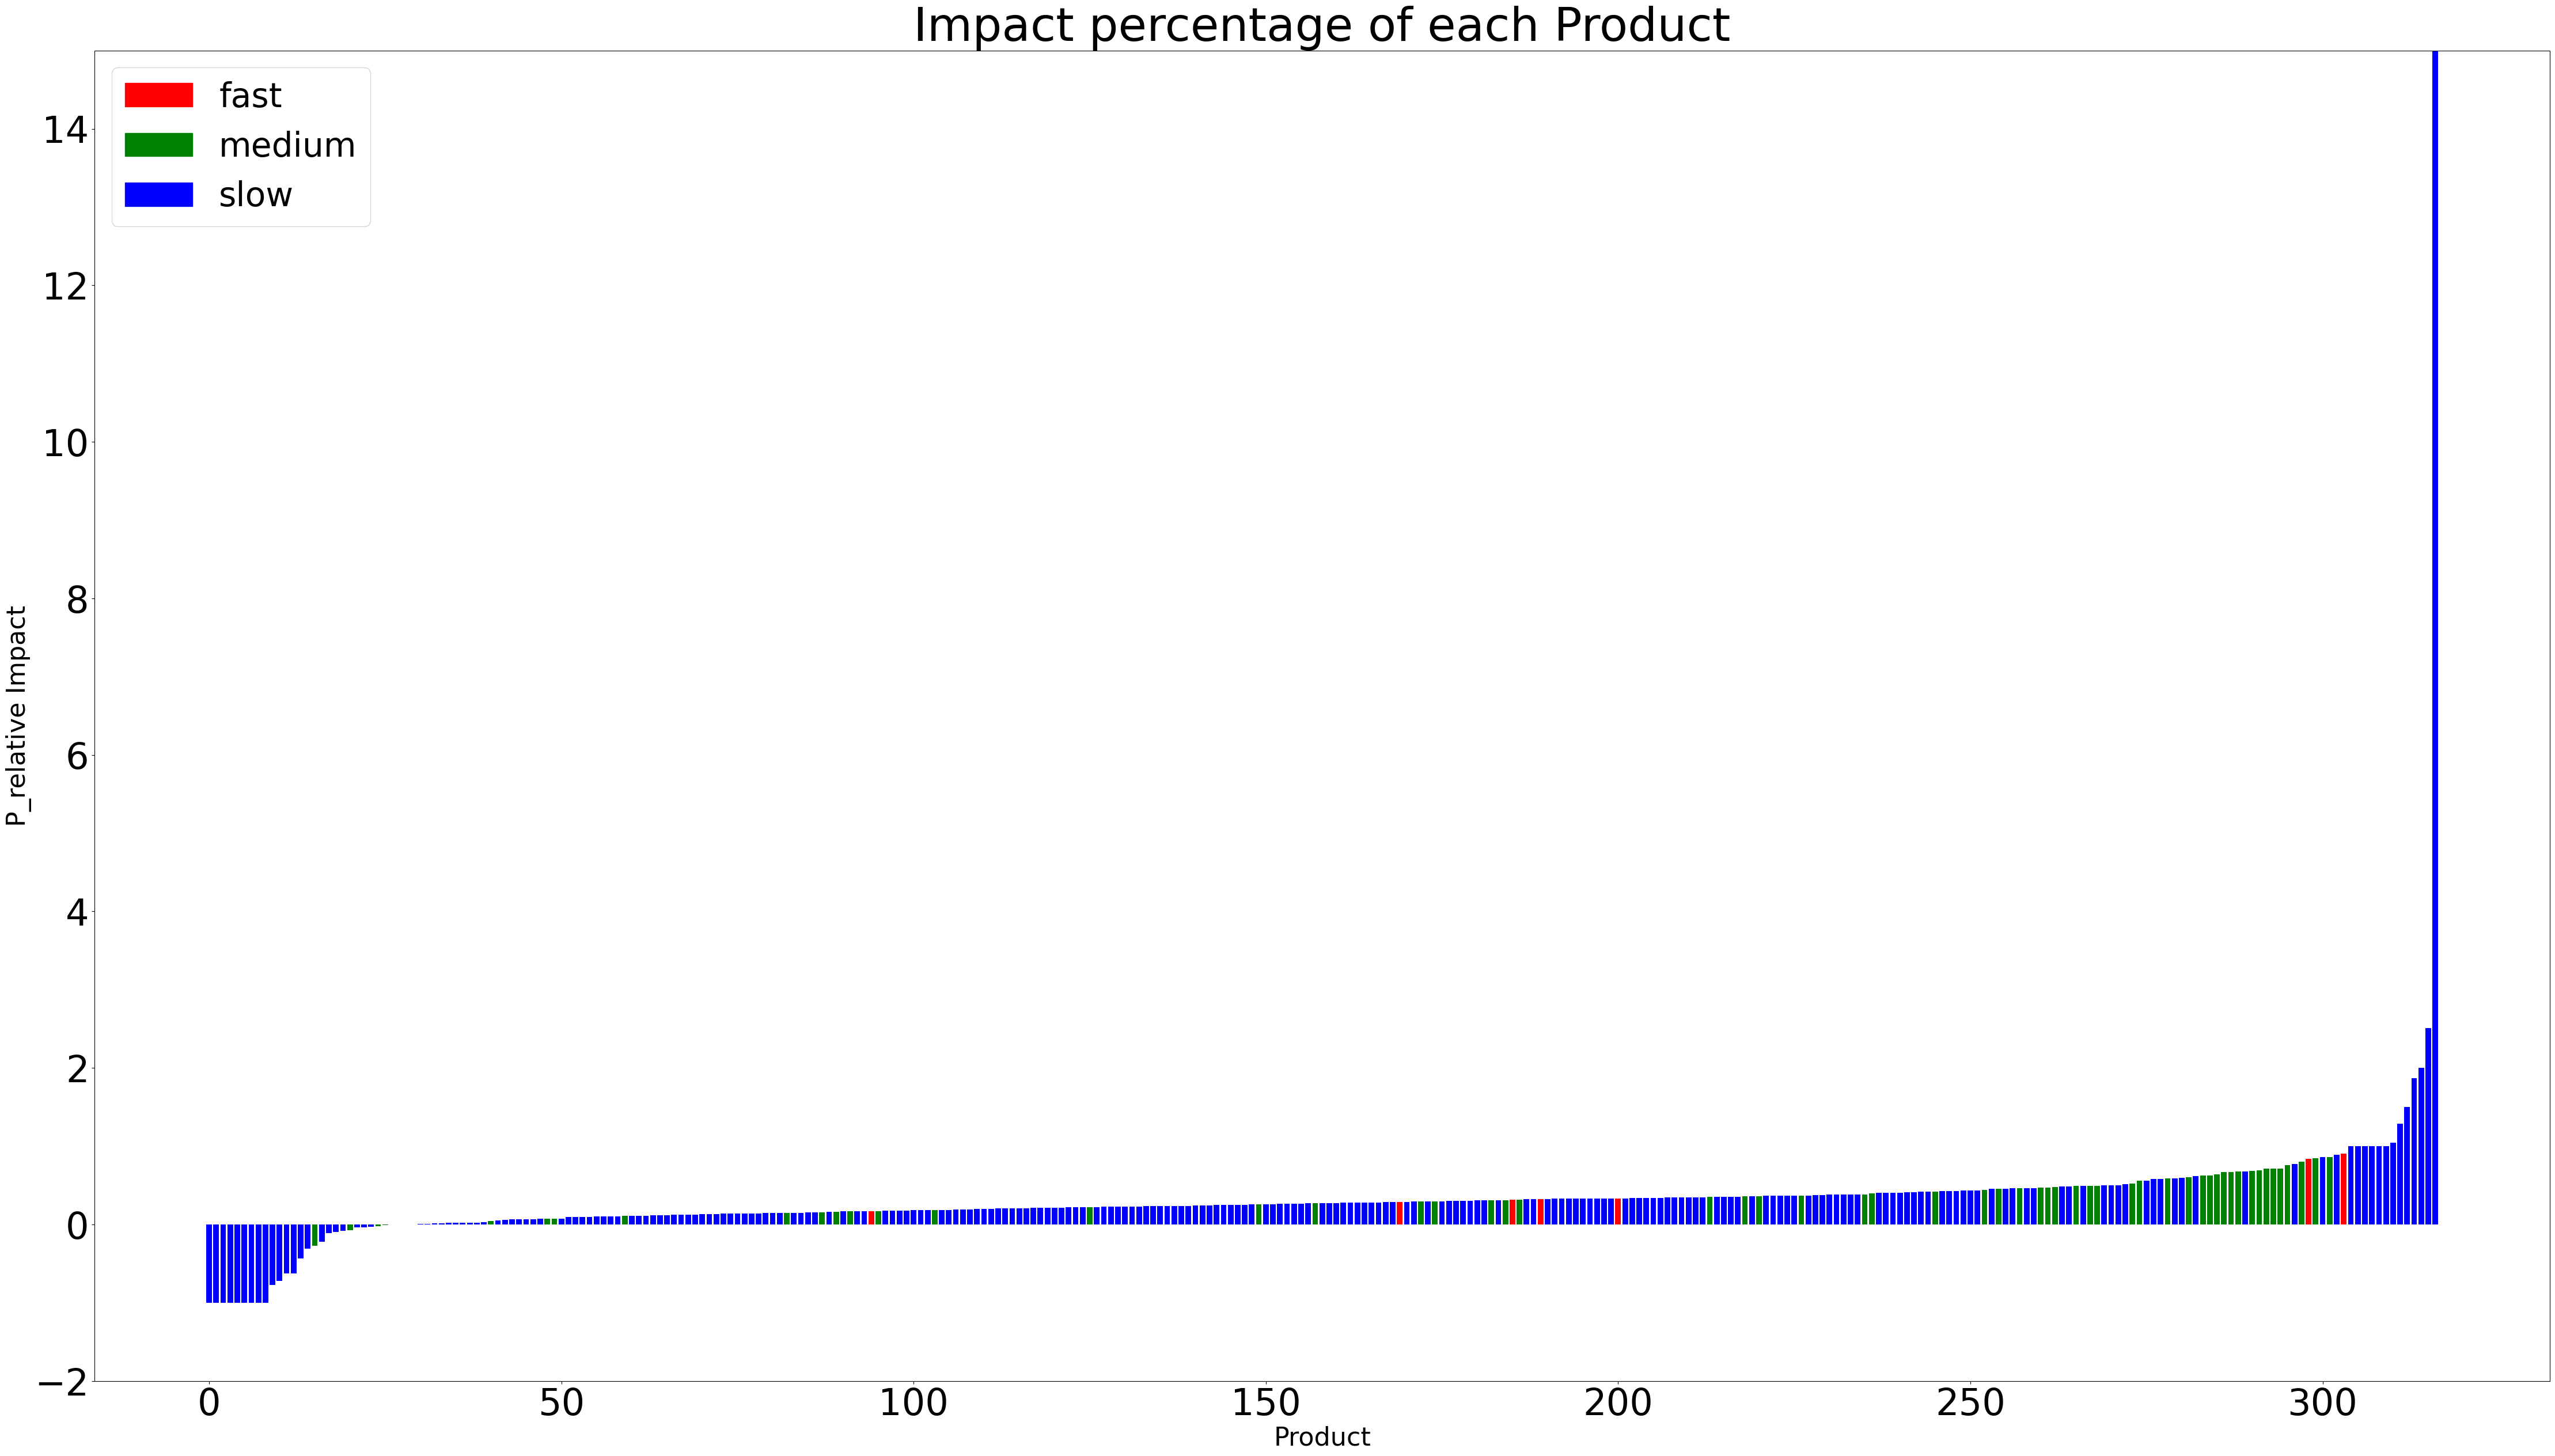

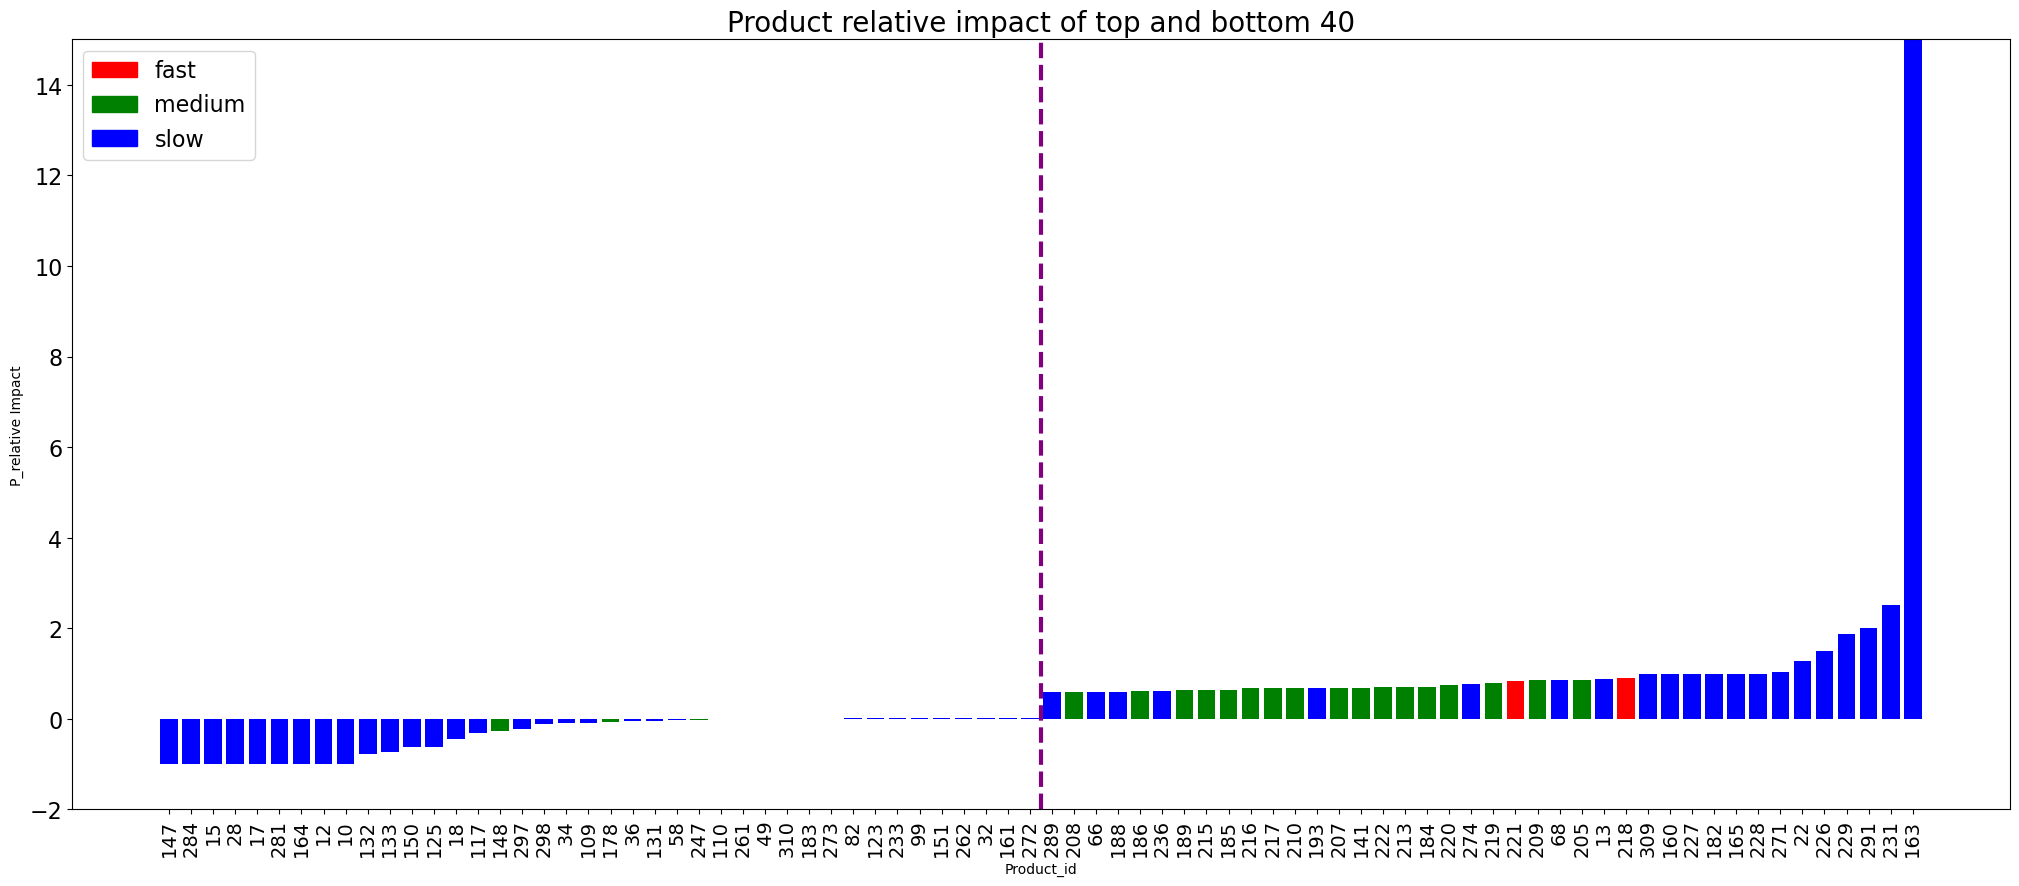

P_promo_type
fast      0.558458
medium    0.353695
slow      0.228499
Name: P_relative_impact, dtype: float64


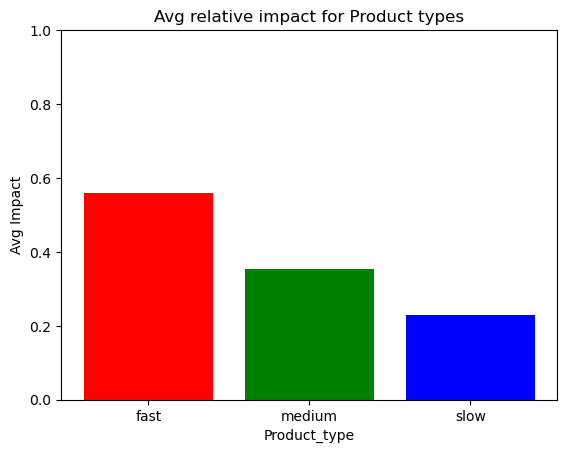

RELATIVE IMPACT


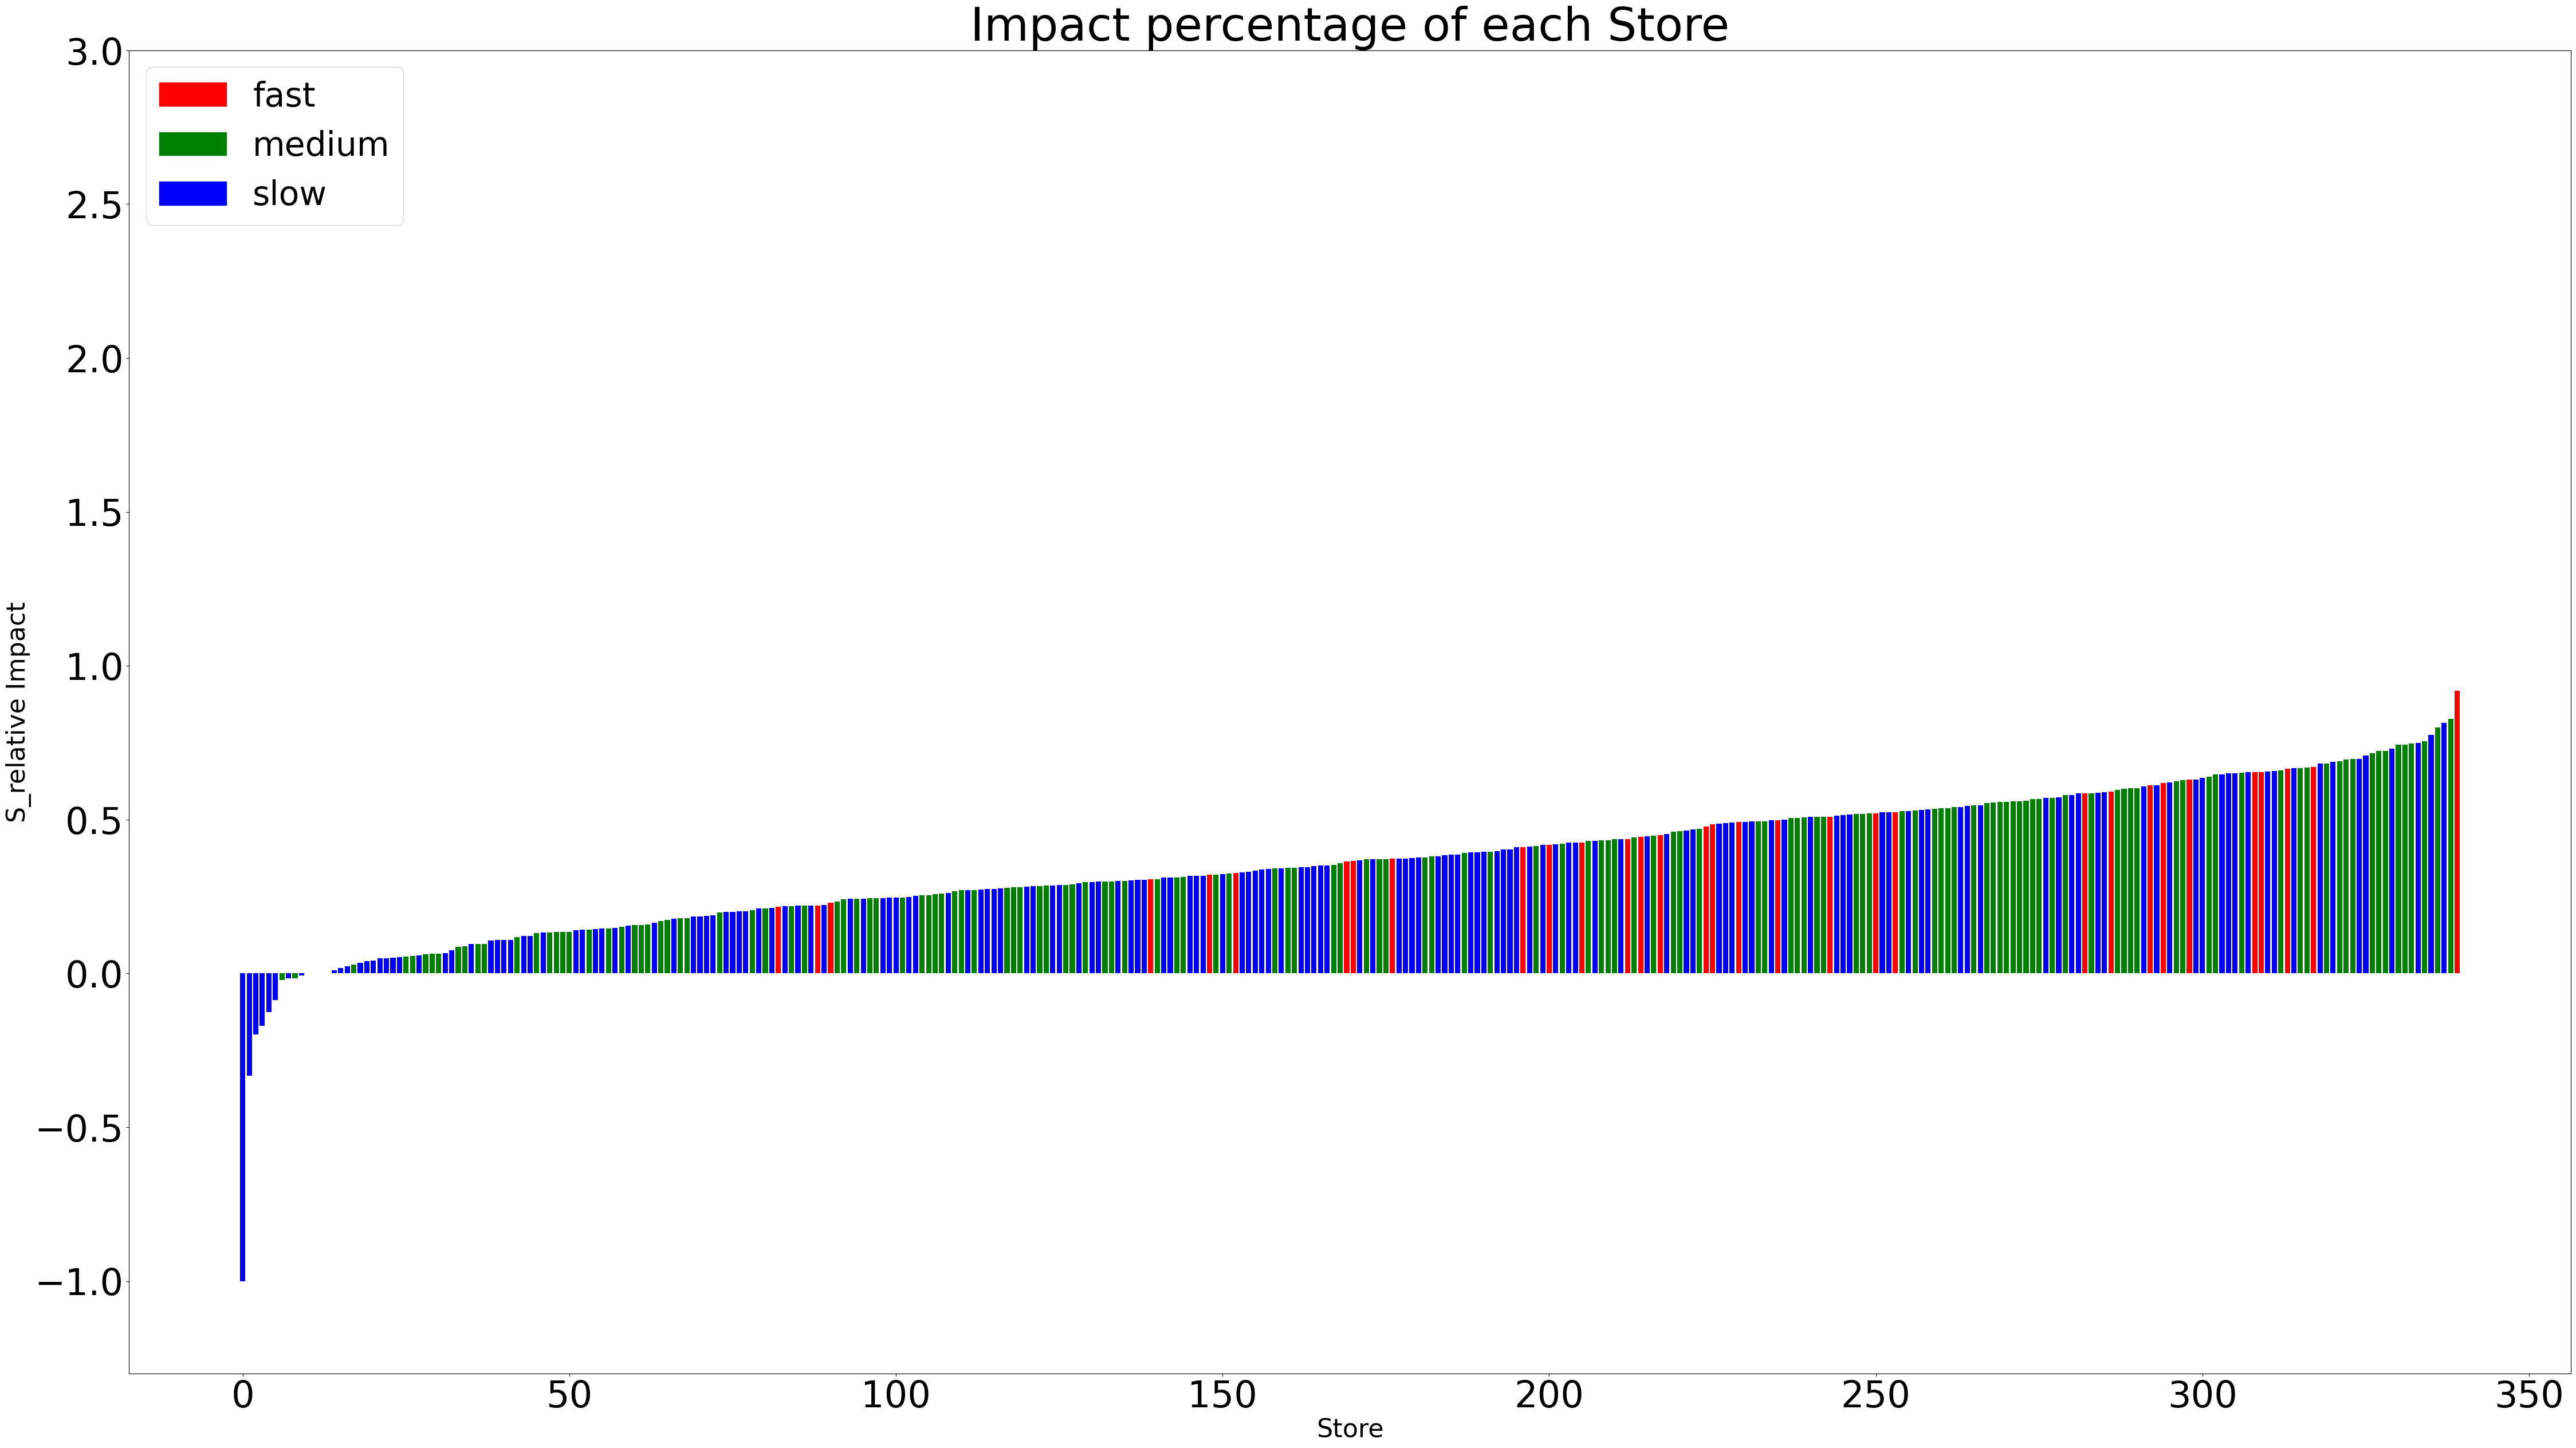

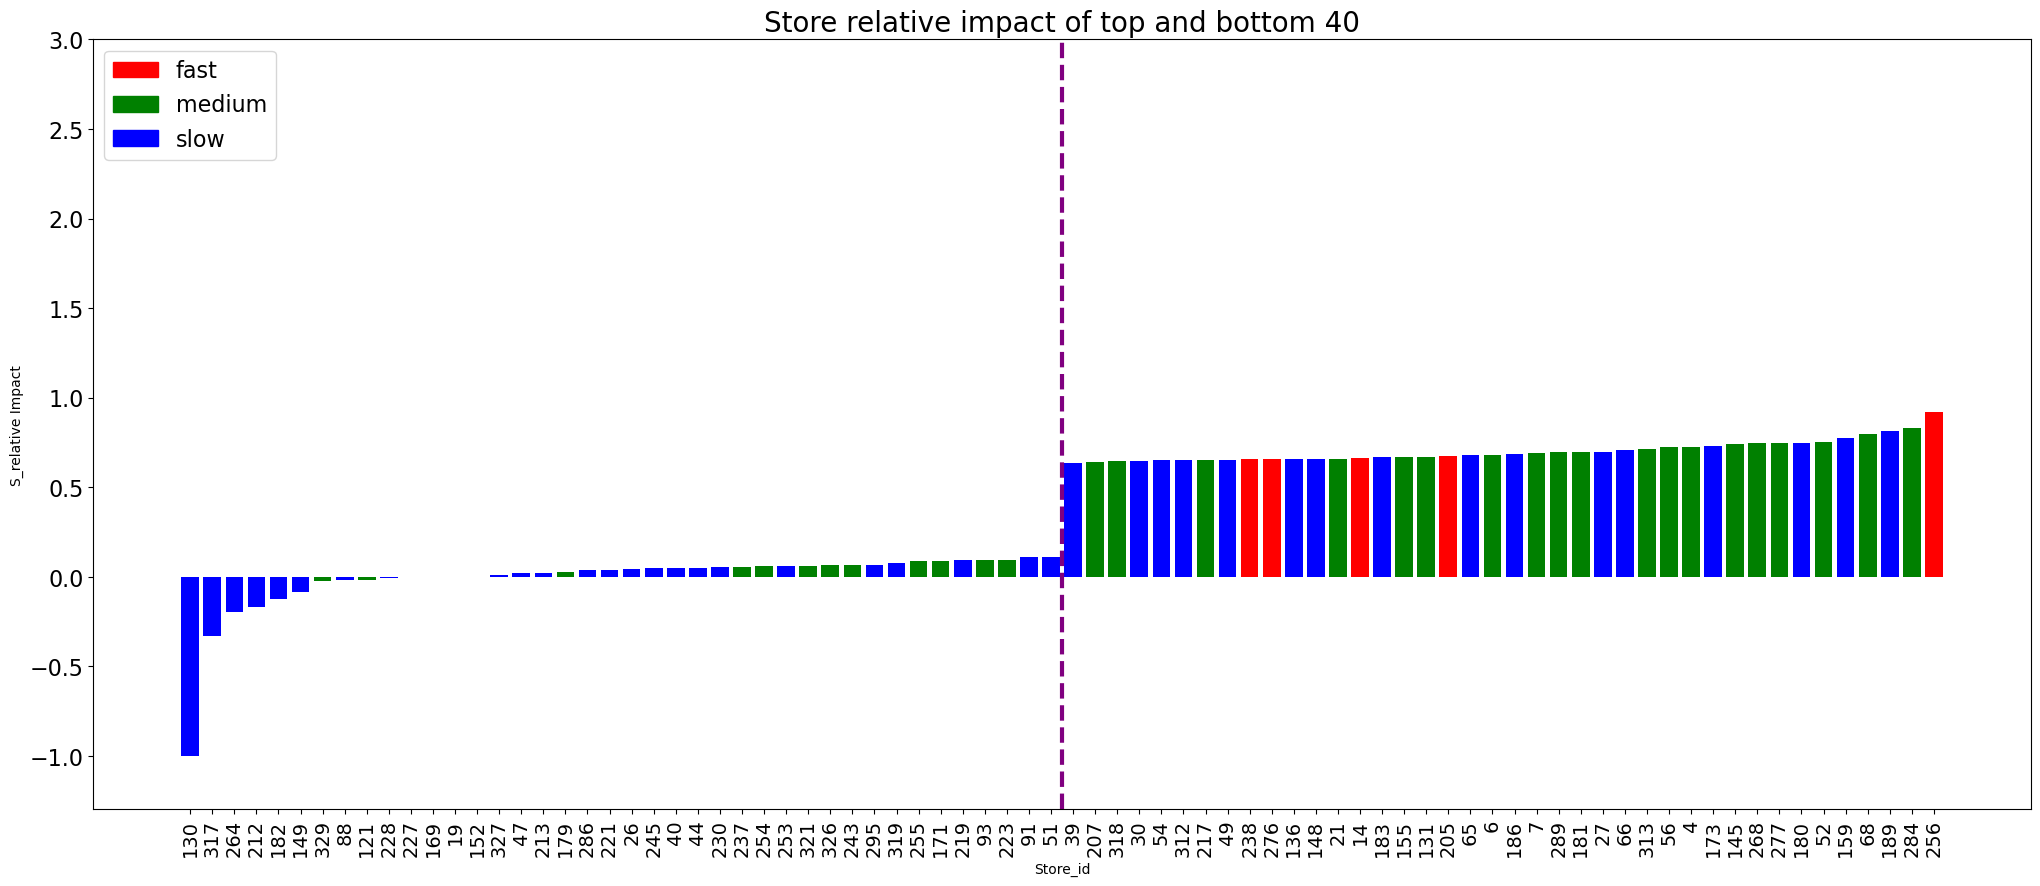

S_promo_type
fast      0.507894
medium    0.359865
slow      0.111768
Name: S_relative_impact, dtype: float64


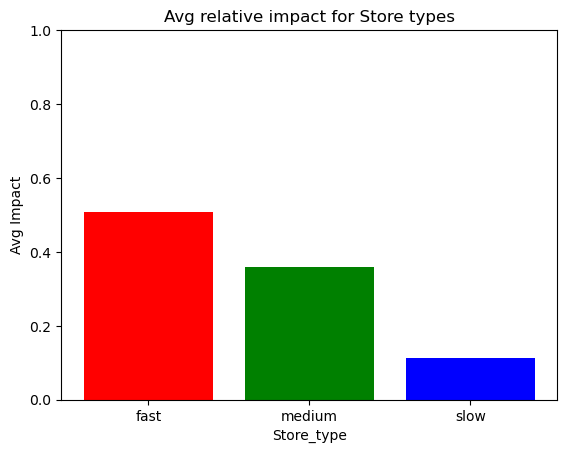

In [9]:
show = True
type = "Promo"

#PROMO PxS weekly sale
promo_weekly_a = promo_sale_to_weekly(promo_sales_a)

#PROMO  AVG weekly P per S sale
promo_product_avg_a = item_avg(promo = 'PROMO',
                               item_name = 'Product',
                               p_np_sales = promo_sales_a,
                               all_items = all_products)

#PROMO  AVG weekly S per P sale
promo_store_avg_a = item_avg(promo = 'PROMO',
                               item_name = 'Store',
                               p_np_sales = promo_sales_a,
                               all_items = all_stores)


#PRODUCT
product_features = item_relative_impact(item_type = "Product", 
                                        n_item = n_product, 
                                        item_promo_avg = promo_product_avg_a,
                                        item_non_promo_avg = non_promo_product_avg_a,
                                        item_non_promo_label = non_promo_product_label,
                                        item_hsh = p_hsh, 
                                        centers_item = centers_avg_p, 
                                        show=show)

#STORE
store_features = item_relative_impact(item_type = "Store",
                                      n_item = n_store, 
                                      item_promo_avg = promo_store_avg_a,
                                      item_non_promo_avg = non_promo_store_avg_a,
                                      item_non_promo_label = non_promo_store_label,
                                      item_hsh = s_hsh, 
                                      centers_item = centers_avg_s,
                                      show=show)

<h1>A- f, g</h1>

In [10]:
#produdct
print('PRODUCT:')
fast_p = product_features[product_features['P_non_promo_type']=='fast']['P_relative_impact']
slow_p = product_features[product_features['P_non_promo_type']=='slow']['P_relative_impact']
 
percentile_5 = slow_p.quantile(0.05)
percentile_95 = slow_p.quantile(0.95)
slow_p = slow_p[(slow_p >= percentile_5) & (slow_p <= percentile_95)].to_numpy()

sig_p = ttest_ind(fast_p, slow_p)
print("assumption: equal var")
print(sig_p)

sig_p = ttest_ind(fast_p, slow_p, equal_var=False)
print("assumption: NOT equal var")
print(sig_p)


#Store
print('STORE:')
fast_s = store_features[store_features['S_non_promo_type']=='fast']['S_relative_impact'].to_numpy()
slow_s = store_features[store_features['S_non_promo_type']=='slow']['S_relative_impact'].to_numpy()


sig_s = ttest_ind(slow_s, fast_s)
print("assumption: equal var")
print(sig_s)

sig_p = ttest_ind(fast_s, slow_s, equal_var=False)
print("assumption: NOT equal var")
print(sig_s)
#t-test to check if there difference in the impacts of promotions on Fast vs Slow items

PRODUCT:
assumption: equal var
TtestResult(statistic=3.0062265389359464, pvalue=0.0029360463548596316, df=232.0)
assumption: NOT equal var
TtestResult(statistic=1.8473086229075488, pvalue=0.11316292318849609, df=6.1315354656194945)
STORE:
assumption: equal var
TtestResult(statistic=-3.712374350050647, pvalue=0.00026651336293777024, df=199.0)
assumption: NOT equal var
TtestResult(statistic=-3.712374350050647, pvalue=0.00026651336293777024, df=199.0)


In [12]:
def create_target(promo_weekly, non_promo_weekly, epsilon=10**-8):
    
    #produt Xitem pair avg weekly sale -- Non-Promo Time
    pxs_non_promo_sale = non_promo_weekly.groupby(['ProductCode','StoreCode'])['SalesQuantity'].mean()
    #produt - item pair avg weekly sale -- Promo Time
    pxs_promo_sale = promo_weekly.groupby(['ProductCode','StoreCode'])['SalesQuantity'].mean()

    # find the missing pxs pairs and add
    missing_non_promo_pxs = set(pxs_non_promo_sale.index).difference(set(pxs_promo_sale.index))
    missing_promo_pxs = set(pxs_promo_sale.index).difference(set(pxs_non_promo_sale.index))
    #create series
    missing_non_promo_pxs = pd.Series(0,index=missing_non_promo_pxs, name='SalesQuantity')
    missing_non_promo_pxs.index.names = ['ProductCode', 'StoreCode']

    missing_promo_pxs = pd.Series(0, index=missing_promo_pxs, name='SalesQuantity')
    missing_promo_pxs.index.names = ['ProductCode', 'StoreCode']

    #add the missings
    pxs_non_promo_sale = pd.concat([pxs_non_promo_sale, missing_promo_pxs])
    pxs_non_promo_sale = pxs_non_promo_sale.sort_index()
    
    pxs_promo_sale = pd.concat([pxs_promo_sale, missing_non_promo_pxs])
    pxs_promo_sale = pxs_promo_sale.sort_index()
    
    #pxs impact calculation -- which will be the value for the model to predict
    pxs_impact = (pxs_promo_sale - pxs_non_promo_sale) / (pxs_non_promo_sale.abs() + epsilon)
    pxs_impact.name = 'pxs_relative_impact'

    print(pxs_non_promo_sale.shape)
    print(pxs_promo_sale.shape)
    print(pxs_impact.shape)
    
    return pxs_non_promo_sale, pxs_impact



In [14]:
print(X_data)

                       P_non_promo_avg_SQ  P_promo_avg_SQ P_non_promo_type  \
ProductCode StoreCode                                                        
1           1                    3.575208        4.237514           medium   
            2                    3.575208        4.237514           medium   
            3                    3.575208        4.237514           medium   
            4                    3.575208        4.237514           medium   
            5                    3.575208        4.237514           medium   
...                                   ...             ...              ...   
317         335                  0.406390        0.570510             slow   
            337                  0.406390        0.570510             slow   
            338                  0.406390        0.570510             slow   
            339                  0.406390        0.570510             slow   
            340                  0.406390        0.570510       

In [15]:
pxs_non_promo_sale_a, pxs_impact_a = create_target(promo_weekly_a, non_promo_weekly_a)

print("CREATING FEATURES:")
#combine store and product features created for question A and the extra hierarchical categorical data assignment1.1c.csv

featuresextra = features1c.set_index(['ProductCode'])

all_product_features = product_features.join(featuresextra)
feature_df = all_product_features.reset_index().join(store_features.reset_index(), how='cross')
feature_df = feature_df.set_index(['ProductCode','StoreCode'])


X_data = feature_df.loc[list(pxs_impact_a.index)]
X_data['pxs_non_promo_sale'] = pxs_non_promo_sale_a

# Droping some columns and engineering some features
#columns_to_drop = ['P_promo_SQ', 'S_promo_SQ','P_promo_type','S_promo_type','P_non_promo_type','S_non_promo_type']
columns_to_drop = ['P_promo_avg_SQ', 'S_promo_avg_SQ']
X_data = X_data.drop(columns=columns_to_drop)



categorical_features = ['P_non_promo_type', 'P_promo_type', 'S_non_promo_type', 'S_promo_type', 'ProductGroup1', 'ProductGroup2']
category_cid = [i for i, idx, in enumerate(X_data) if idx in categorical_features]

for col in categorical_features:
    X_data[col] = X_data[col].astype("category")

Y = pxs_impact_a
print("X_data:", X_data.shape)
print("Y:", Y.shape)

x_train, x_val, y_train, y_val = train_test_split(X_data, Y, test_size=0.15)

#X_data = X_data.drop(columns=columns_to_drop)
#print(X_data.head())


(83556,)
(83556,)
(83556,)
CREATING FEATURES:
X_data: (83556, 15)
Y: (83556,)


<h1>------------------------B----------------------------</h1>

**Preparing Test data**

In [12]:
promotions_b = pd.DataFrame([["Promo5","9/1/2015","9/6/2015"]], columns= ['Period','StartDate','EndDate'])

promo_sales_b, non_promo_sales_b = promo_and_non_promo(sales1b, promotions_b )
promo_weeks_b = {36}
print('promo_weeks',promo_weeks_b)

all_products_b = set(np.arange(len(sales1b['ProductCode'].unique()))+1)
all_stores_b = set(np.arange(len(sales1b['StoreCode'].unique()))+1)
n_week_b = len(sales1b["Week"].unique())
n_product_b, n_store_b = len(all_products_b), len(all_stores_b)


- 1028121 rows, 4 columns
- there are 0 null values in the data frame
- number of stores: 328, number of product: 302

Promotion Dates
 week  week StartDate EndDate
   36    36   Tuesday  Sunday

Promo vs Non Promo Time
# of no promo sales (986646, 6)
# of promo sales (41475, 6)
promo_weeks {36}


**Features for Test**

In [23]:
epsilon= 10**-8

# DATA B

#NON- PROMO 
#Non-promo time PxSxWeekly Sales
non_promo_weekly_b = non_promo_sale_to_weekly(non_promo_sales_b, promo_weeks_b)


#Non-promo time AVG weekly P per S Sales
non_promo_product_avg_b = item_avg(promo = 'NON-PROMO', 
                                 item_name = 'Product', 
                                 p_np_sales = non_promo_sales_b,
                                 all_items = all_products,
                                 promo_weeks=promo_weeks_b)

#Non-promo time AVG weekly S per P Sales
non_promo_store_avg_b = item_avg(promo = 'NON-PROMO', 
                                 item_name = 'Store', 
                                 p_np_sales = non_promo_sales_b,
                                 all_items = all_stores,
                                 promo_weeks=promo_weeks_b)


#PROMO PxS weekly sale
promo_weekly_b = promo_sale_to_weekly(promo_sales_b)

#PROMO  AVG weekly P per S sale
promo_product_avg_b = item_avg(promo = 'PROMO',
                               item_name = 'Product',
                               p_np_sales = promo_sales_b,
                               all_items = all_products)

#PROMO  AVG weekly S per P sale
promo_store_avg_b = item_avg(promo = 'PROMO',
                               item_name = 'Store',
                               p_np_sales = promo_sales_b,
                               all_items = all_stores)


pxs_non_promo_sale_b, pxs_impact_b = create_target(promo_weekly_b, non_promo_weekly_b)

#PREPARING X_test
X_test = feature_df.loc[list(pxs_impact_b.index)]
X_test['pxs_non_promo_sale'] = pxs_non_promo_sale_b
X_test['P_non_promo_avg_SQ'] = X_test.apply(lambda x: non_promo_product_avg_b.loc[x.name[0]],axis=1)
X_test['S_non_promo_avg_SQ'] = X_test.apply(lambda x: non_promo_store_avg_b.loc[x.name[1]],axis=1)

# Droping some columns and engineering some features
#columns_to_drop = ['P_promo_SQ', 'S_promo_SQ','P_promo_type','S_promo_type','P_non_promo_type','S_non_promo_type']
columns_to_drop = ['P_promo_avg_SQ', 'S_promo_avg_SQ']
X_test = X_test.drop(columns=columns_to_drop)

#X_test = pd.get_dummies(X_test, columns=['P_non_promo_type'], prefix='P_non_promo_type')
#X_test = pd.get_dummies(X_test, columns=['P_promo_type'], prefix='P_promo_type')
#X_test = pd.get_dummies(X_test, columns=['S_non_promo_type'], prefix='S_non_promo_type')
#X_test = pd.get_dummies(X_test, columns=['S_promo_type'], prefix='S_promo_type')


categorical_features = ['P_non_promo_type', 'P_promo_type', 'S_non_promo_type', 'S_promo_type', 'ProductGroup1', 'ProductGroup2']
category_cid = [i for i, idx, in enumerate(X_test) if idx in categorical_features]

for col in categorical_features:
    X_test[col] = X_test[col].astype("category")

Y_test = pxs_impact_b
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)


(73835,)
(73835,)
(73835,)
X_test: (73835, 15)
Y_test: (73835,)


In [24]:
display(X_test)

P_non_promo_avg_SQ P_non_promo_type P_promo_type  \
ProductCode StoreCode                                                     
1           1                    3.420773           medium       medium   
            2                    3.420773           medium       medium   
            3                    3.420773           medium       medium   
            4                    3.420773           medium       medium   
            5                    3.420773           medium       medium   
...                                   ...              ...          ...   
317         336                  0.432851             slow         slow   
            337                  0.432851             slow         slow   
            338                  0.432851             slow         slow   
            339                  0.432851             slow         slow   
            340                  0.432851             slow         slow   

                       P_relative_impact  P_type_avg_impact  P_type_shift  \
ProductCode StoreCode                                                       
1           1                   0.185250           0.353695             0   
            2                   0.185250           0.353695             0   
            3                   0.185250           0.353695             0   
            4                   0.185250           0.353695             0   
            5                   0.185250           0.353695             0   
...                                  ...                ...           ...   
317         336                 0.403849           0.228499             0   
            337                 0.403849           0.228499             0   
            338                 0.403849           0.228499             0   
            339                 0.403849           0.228499             0   
            340                 0.403849           0.228499             0   

                      ProductGroup1 ProductGroup2  S_non_promo_avg_SQ  \
ProductCode StoreCode                                                   
1           1                     A             5            2.923942   
            2                     A             5            6.151119   
            3                     A             5            2.554560   
            4                     A             5            3.182743   
            5                     A             5            2.620933   
...                             ...           ...                 ...   
317         336                   J             8            2.860284   
            337                   J             8            3.428078   
            338                   J             8            3.372637   
            339                   J             8            1.005396   
            340                   J             8            4.061485   

                      S_non_promo_type S_promo_type  S_relative_impact  \
ProductCode StoreCode                                                    
1           1                   medium       medium           0.240225   
            2                     fast         fast           0.410952   
            3                     slow       medium           0.246118   
            4                   medium         fast           0.723004   
            5                     slow       medium           0.271026   
...                                ...          ...                ...   
317         336                   slow       medium           0.317620   
            337                 medium         fast           0.602750   
            338                 medium       medium           0.433268   
            339                 medium         fast           0.530012   
            340                 medium         fast           0.253283   

                       S_type_avg_impact  S_type_shift  pxs_non_promo_sale  
ProductCode StoreCode                                  

In [33]:
epsilon= 10**-8

type = 'Non-Promo'
non_promo_weekly_b, product_non_promo_weekly_per_store_b, \
store_non_promo_weekly_per_product_b, product_non_promo_avg_b,\
store_non_promo_avg_b = weekly_sales_analysis(type, non_promo_sales_b, promo_weeks_b, promotions_b)

type = "Promo"
promo_weekly_b, product_promo_avg_b, store_promo_avg_b  = weekly_sales_analysis(type, promo_sales_b, promo_weeks_b, promotions_b)

pxs_non_promo_sale_b, pxs_impact_b = create_target(promo_weekly_b, non_promo_weekly_b)


#PREPARING X_test
X_test = feature_df.loc[list(pxs_impact_b.index)]
X_test['pxs_non_promo_sale'] = pxs_non_promo_sale_b
X_test['P_non_promo_avg_SQ'] = X_test.apply(lambda x: product_non_promo_avg_b.loc[x.name[0]],axis=1)
X_test['S_non_promo_avg_SQ'] = X_test.apply(lambda x: store_non_promo_avg_b.loc[x.name[1]],axis=1)

# Droping some columns and engineering some features
#columns_to_drop = ['P_promo_SQ', 'S_promo_SQ','P_promo_type','S_promo_type','P_non_promo_type','S_non_promo_type']
columns_to_drop = ['P_promo_avg_SQ', 'S_promo_SQ']
X_test = X_test.drop(columns=columns_to_drop)

#X_test = pd.get_dummies(X_test, columns=['P_non_promo_type'], prefix='P_non_promo_type')
#X_test = pd.get_dummies(X_test, columns=['P_promo_type'], prefix='P_promo_type')
#X_test = pd.get_dummies(X_test, columns=['S_non_promo_type'], prefix='S_non_promo_type')
#X_test = pd.get_dummies(X_test, columns=['S_promo_type'], prefix='S_promo_type')


categorical_features = ['P_non_promo_type', 'P_promo_type', 'S_non_promo_type', 'S_promo_type', 'ProductGroup1', 'ProductGroup2']
category_cid = [i for i, idx, in enumerate(X_test) if idx in categorical_features]

for col in categorical_features:
    X_test[col] = X_test[col].astype("category")

Y_test = pxs_impact_b
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)



(73835,)
(73835,)
(73835,)
X_test: (73835, 15)
Y_test: (73835,)


In [32]:
X_test.iloc[0].name[] ==1

True

In [34]:
display(X_test)

P_non_promo_SQ P_non_promo_type P_promo_type  \
ProductCode StoreCode                                                 
1           1                3.420773           medium       medium   
            2                3.420773           medium       medium   
            3                3.420773           medium       medium   
            4                3.420773           medium       medium   
            5                3.420773           medium       medium   
...                               ...              ...          ...   
317         336              0.432851             slow         slow   
            337              0.432851             slow         slow   
            338              0.432851             slow         slow   
            339              0.432851             slow         slow   
            340              0.432851             slow         slow   

                       P_relative_impact  P_type_avg_impact  P_type_shift  \
ProductCode StoreCode                                                       
1           1                   0.185250           0.353695             0   
            2                   0.185250           0.353695             0   
            3                   0.185250           0.353695             0   
            4                   0.185250           0.353695             0   
            5                   0.185250           0.353695             0   
...                                  ...                ...           ...   
317         336                 0.403849           0.228499             0   
            337                 0.403849           0.228499             0   
            338                 0.403849           0.228499             0   
            339                 0.403849           0.228499             0   
            340                 0.403849           0.228499             0   

                      ProductGroup1 ProductGroup2  S_non_promo_SQ  \
ProductCode StoreCode                                               
1           1                     A             5        2.923942   
            2                     A             5        6.151119   
            3                     A             5        2.554560   
            4                     A             5        3.182743   
            5                     A             5        2.620933   
...                             ...           ...             ...   
317         336                   J             8        2.860284   
            337                   J             8        3.428078   
            338                   J             8        3.372637   
            339                   J             8        1.005396   
            340                   J             8        4.061485   

                      S_non_promo_type S_promo_type  S_relative_impact  \
ProductCode StoreCode                                                    
1           1                   medium       medium           0.240225   
            2                     fast         fast           0.410952   
            3                     slow       medium           0.246118   
            4                   medium         fast           0.723004   
            5                     slow       medium           0.271026   
...                                ...          ...                ...   
317         336                   slow       medium           0.317620   
            337                 medium         fast           0.602750   
            338                 medium       medium           0.433268   
            339                 medium         fast           0.530012   
            340                 medium         fast           0.253283   

                       S_type_avg_impact  S_type_shift  pxs_non_promo_sale  
ProductCode StoreCode                                                       
1           1                   0.359865             0            1.000000  
     

**MODEL TRAINING**

Linear Regression



In [25]:
columns_one_hot = ['P_promo_type','S_non_promo_type','S_promo_type','ProductGroup1','ProductGroup2']

X_data_lr = pd.get_dummies(X_data, columns=['P_non_promo_type'], prefix='P_non_promo_type')
for col in columns_one_hot:
    X_data_lr = pd.get_dummies(X_data_lr, columns=[col], prefix=col)

X_test_lr = pd.get_dummies(X_test, columns=['P_non_promo_type'], prefix='P_non_promo_type')
for col in columns_one_hot:
    X_test_lr = pd.get_dummies(X_test_lr, columns=[col], prefix=col)

columns_one_hot = ['P_non_promo_type','S_non_promo_type','ProductGroup1','ProductGroup2']

X_simple = X_data[['ProductGroup1','ProductGroup2','P_relative_impact','S_relative_impact','P_non_promo_type','S_non_promo_type']]
for col in columns_one_hot:
    X_simple = pd.get_dummies(X_simple, columns=[col], prefix=col)

X_simple_test = X_test[['ProductGroup1','ProductGroup2','P_relative_impact','S_relative_impact','P_non_promo_type','S_non_promo_type']]
for col in columns_one_hot:
    X_simple_test = pd.get_dummies(X_simple_test, columns=[col], prefix=col)



In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

print("Linear Regression")
print("Plain")
print(X_data_lr.shape)
reg = LinearRegression().fit(X_data_lr.values, Y.values)
print("Score", reg.score(X_data_lr.values, Y.values))
print("Test Score", reg.score(X_test_lr.values, Y_test.values))

print("\nPlain - Simple Data")
print(X_simple.shape)
reg = LinearRegression().fit(X_simple.values, Y.values)
print("Score", reg.score(X_simple.values, Y.values))
print("Test Score", reg.score(X_simple_test.values, Y_test.values))

print("\nPolynomial Kernel 2nd Degree")

poly2 = PolynomialFeatures(2)
X_data_lr_poly2 = poly2.fit_transform(X_data_lr.values)
X_test_lr_poly2 = poly2.fit_transform(X_test_lr.values)
print(X_data_lr_poly2.shape)
reg = LinearRegression().fit(X_data_lr_poly2, Y.values)
print("Train Score", reg.score(X_data_lr_poly2, Y.values))
print("Test Score", reg.score(X_test_lr_poly2, Y_test.values))

print("\nPolynomial Kernel 2nd degree + PCA")
pca = PCA(n_components=800)
X_data_lr_new = pca.fit_transform(X_data_lr_poly2) 
X_test_lr_new = pca.fit_transform(X_test_lr_poly2) 
print(X_data_lr_new.shape)
reg = LinearRegression().fit(X_data_lr_new, Y.values)
print("Score", reg.score(X_data_lr_new, Y.values))
print("Test Score", reg.score(X_test_lr_new, Y_test.values))

Linear Regression
Plain
(83556, 61)
Score 0.019822121659469616
Test Score -0.024357318794628657

Plain - Simple Data
(83556, 48)
Score 0.012586244442784777
Test Score -0.022586682801688074

Polynomial Kernel 2nd Degree
(83556, 1953)
Train Score 0.11610806051144507
Test Score -8231024359.430056

Polynomial Kernel 2nd degree + PCA
(83556, 800)
Score 0.11754757437755348
Test Score -703498.4882573908


Random Forrest Regressor

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

print('Random Forrest Regressor')
X_data_lr
print('\nmax_depth: 3')
regr = RandomForestRegressor(max_depth=3, random_state=0)
regr.fit(X_data_lr.values, Y)
print("Train Score",regr.score(X_data_lr.values, Y.values))
print("Test Score",regr.score(X_test_lr.values, Y_test.values))


print('\nmax_depth: 5')
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_data_lr, Y)
print("Train Score",regr.score(X_data_lr, Y))
print("Test Score",regr.score(X_test_lr, Y_test))

print('\nmax_depth: 15')
regr = RandomForestRegressor(max_depth=15, random_state=0)
regr.fit(X_data_lr, Y)
print("Train Score",regr.score(X_data_lr, Y))
print("Test Score",regr.score(X_test_lr, Y_test))

print('\nmax_depth: 30')
regr = RandomForestRegressor(max_depth=30, random_state=0)
regr.fit(X_data_lr, Y)
print("Train Score",regr.score(X_data_lr, Y))
print("Test Score",regr.score(X_test_lr, Y_test))

print('\nmax_depth: 45')
regr = RandomForestRegressor(max_depth=45, random_state=0)
regr.fit(X_data_lr, Y)
print("Train Score",regr.score(X_data_lr, Y))
print("Test Score",regr.score(X_test_lr, Y_test))

Random Forrest Regressor

max_depth: 3
Train Score 0.3473982645005408
Test Score -0.14535509946051617

max_depth: 5
Train Score 0.505103545295897
Test Score -0.3354850606934541

max_depth: 15
Train Score 0.8666553827989212
Test Score -0.6774016234787261

max_depth: 30
Train Score 0.8966135090333889
Test Score -0.7075936613568885

max_depth: 45
Train Score 0.8973829507278983
Test Score -0.7534868752004527


XGBOOst

In [38]:
# Necessary imports
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
				n_estimators = 10, seed = 123)

# Fitting the model
xgb_r.fit(X_data_lr, Y)

# Predict the model
pred = xgb_r.predict(X_test_lr)

# RMSE Computation
rmse = np.sqrt(MSE(Y_test, pred))
mae = MAE(Y_test, pred)

print("RMSE : % f" %(rmse))
print("MAE : % f" %(mae))


[20:59:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1691196801708/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  49346365.047647
MAE :  5383294.524358


In [49]:
print(lgb_train.data)

None


In [201]:

#SCRIBBLES AND PLOTS
#Histogram of avg daily sell countfor each store
# product_total_sales = sales1a.groupby(['ProductCode'])['SalesQuantity'].sum()
# plt.title("Total Sales Quantity for each Product")
# plt.bar(product_total_sales.index.values, product_total_sales)
# plt.show()
#print("check1", product_total_sales.sum() == sales1a['SalesQuantity'].sum())


#Histogram of avg daily sell countfor each product
# store_total_sales = sales1a.groupby(['StoreCode'])['SalesQuantity'].sum()  
# plt.title("Total Sales Quantity for each Store")
# plt.bar(store_total_sales.index.values, store_total_sales)
# plt.show()
#print("check2", store_total_sales.sum() == sales1a['SalesQuantity'].sum())


#Histogram of daily sell 
# date_total_sales = sales1a.groupby(['Date'])['SalesQuantity'].sum()
# plt.bar(date_total_sales.index.values, date_total_sales)
# plt.show()


# Bar plot of item weekly sales 
# i = 1
# df = [product_weekly_per_store, store_weekly_per_product][i]     
# items = ['Product','Store']
# n = [317+1,340+1][i]
# for i_id in range(1,n):
#     p = df[df[items[i]+'Code'] == i_id]
#     plt.title(f"{items[i]}_{i_id} weekly sale per {items[(i+1)%2]}")
#     hs = np.zeros(32)
#     for idx in range(len(p)):
#         r = p.iloc[idx]  
#         hs[int(r.Week)] = r.SalesQuantity
#     plt.bar(np.arange(len(hs)), hs)
#     plt.show()



#Displaying produdcts and labels
# print(X_product.shape)
# colors = {l:c for l, c in zip(sorted_index, labels)}
# for i, x in enumerate(X_product):
#     plt.title(f"Product_{i+1}, class_{colors[kmeans_p.labels_[i]][0]}")
#     plt.bar(np.arange(len(x)), x, color=colors[kmeans_p.labels_[i]][1])
#     plt.show()



# #Product got sold  on promo time and non-promo time

# all_products = set(np.arange(n_product)+1)

# p_no_promo = non_promo_sales.groupby(['ProductCode'])['SalesQuantity'].sum() > 0
# product_no_promo = set(p_no_promo[p_no_promo].index)

# p_promo = promo_sales.groupby(['ProductCode'])['SalesQuantity'].sum() > 0
# product_promo =set(p_promo[p_promo].index)

# all_sold = product_promo.union(product_no_promo)

# # print("\nPRODUCT:")
# # print("Product not sold at all", all_products.difference(all_sold))
# # print("Product sold on promo time but not on non-promo time",product_promo.difference(product_no_promo))
# # print("Product sold on non-promo time but not on promo time, len is ", len(product_no_promo.difference(product_promo)),",",product_no_promo.difference(product_promo))

# #Shopes got sold  on promo time and non-promo time

# all_stores = set(np.arange(n_store)+1)

# s_no_promo = non_promo_sales.groupby(['StoreCode'])['SalesQuantity'].sum() > 0
# store_no_promo = set(s_no_promo[s_no_promo].index)

# s_promo = promo_sales.groupby(['StoreCode'])['SalesQuantity'].sum() > 0
# store_promo = set(s_promo[s_promo].index)


# all_store_sold = store_promo.union(store_no_promo)
# # print("\nSTORE:")
# # print("Store not sold at all", all_stores.difference(all_store_sold))
# # print("Store that sold products on promo time but not on non-promo time",store_promo.difference(store_no_promo))
# # print("Store that sold on non-promo time but not on promo time",store_no_promo.difference(store_promo))

In [ ]:
import pandas as pd

# Create a sample DataFrame
data = {'Name': ['Alice', 'Bob', 'Charlie'],
        'Age': [25, 30, 28],
        'City': ['New York', 'Los Angeles', 'Chicago']}

df = pd.DataFrame(data)

# Slicing using .iloc[]
sliced_df = df.iloc[0:2, :]

# Display the original DataFrame and sliced DataFrame
print("Original DataFrame:")
print(df)
print("\nSliced DataFrame:")
print(sliced_df)

# Modify variables in the sliced DataFrame
#sliced_df.loc[:,'Age'] = [26, 31]
sliced_df['Age'] = [26, 31]

# Display the modified sliced DataFrame
print("\nModified Sliced DataFrame:")
print(sliced_df)
 
# Display the original DataFrame to show that modifications to sliced_df do not affect the original DataFrame
print("\nOriginal DataFrame (after modifying sliced_df):")
print(df)
